# Resources and cost

One thing that needs to be present nowadays is that the execution on quantum hardware is still quite expensive given the status of the technology, maintenance required and well, there are not so many quantum companies out there.

In [ ]:
!pip install amazon-braket-sdk amazon-braket-pennylane-plugin

Pennylane already counts with a resource estimation mechanisms so it is easy to evaluate how much it will require to train a given circuit.

In [7]:
import pennylane as qml
from pennylane import numpy as np

wires = 2  # Number of qubits

dev = qml.device("braket.local.qubit", wires=wires)

def circuit(params):
    qml.Hadamard(wires=0)
    qml.RY(params[0], wires=0)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(1))

qnode_local = qml.QNode(circuit, dev)

In [9]:
params = np.array([0.1], requires_grad=True)

with qml.Tracker(dev) as tracker:
    print("Expectation value of circuit:", qnode_local(params))

Expectation value of circuit: -0.09983341664682821


In [10]:
print(tracker.history)

{'executions': [1], 'shots': [None], 'braket_task_id': ['0f6c047e-fb58-48d5-bc85-1ff4a1538115'], 'batches': [1], 'batch_len': [1]}


In [11]:
with qml.Tracker(dev) as tracker:
    print("Gradient of circuit:", qml.grad(qnode_local)(params))

print(tracker.history)

Gradient of circuit: [-0.99500417]
{'executions': [1, 1, 1], 'shots': [None, None, None], 'braket_task_id': ['2d68103f-3817-422c-9100-6b59b236a614', 'e44a156f-c78f-4a57-8426-0fa0c6133d76', 'abba84cb-3ff5-4b44-b8b9-cdae7ba16ed8'], 'batches': [1, 1], 'batch_len': [1, 2]}


In [13]:
with qml.Tracker(dev) as tracker:
    qml.grad(qnode_local)(params, shots=10)
print(tracker.totals)

{'executions': 3, 'shots': 30, 'batches': 2, 'batch_len': 3}


Once we have a clear understanding in what resources are required and the potential cost it could cause when moving to a device in AWS, we can perform additional validations.

In [ ]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires
)

qnode_remote = qml.QNode(circuit, dev_remote)

One must need to consider any operation against the device will introduce **costs** so be sure to try with minimum number of shots before going all the way training a PQC.

## Azure

We will use Azure's Qiskit plugin to modify one of our previous worloads and get its cost estimation for available devices.

In [ ]:
!pip install azure-quantum[qiskit]

In [2]:
import os
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

from azure.quantum.qiskit import AzureQuantumProvider
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/<suscription_id>/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/<qworkspace>",
    location = "eastus"
)

In [3]:
backends = [backend.name() for backend in provider.backends()]

for bname in backends:
    print(bname)

ionq.qpu
ionq.qpu.aria-1
ionq.simulator
quantinuum.hqs-lt-s1
quantinuum.hqs-lt-s1-apival
quantinuum.hqs-lt-s2
quantinuum.hqs-lt-s2-apival
quantinuum.hqs-lt-s1-sim
quantinuum.hqs-lt-s2-sim
quantinuum.qpu.h1-1
quantinuum.sim.h1-1sc
quantinuum.qpu.h1-2
quantinuum.sim.h1-2sc
quantinuum.sim.h1-1e
quantinuum.sim.h1-2e
rigetti.sim.qvm
rigetti.qpu.aspen-11
rigetti.qpu.aspen-m-2
rigetti.qpu.aspen-m-3
microsoft.estimator


We will take as an example the European Call Pricing circuit we used at the end of chapter 4.

In [8]:
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.applications.estimation import EuropeanCallPricing

nqubits = 5
mu = 1.8857218736663879
stddev = 1.3485214461619102
high = 100
low = 2.676853593081561

strike = 7

# construct A operator for QAE composing the uncertainty model and the objective
dist_circ = LogNormalDistribution(nqubits, mu=mu, sigma=stddev**2, bounds=(low, high))

european_call_pricing = EuropeanCallPricing(
    num_state_qubits=nqubits,
    strike_price=strike,
    rescaling_factor=0.05,
    bounds=(low, high),
    uncertainty_model=dist_circ,
)

problem = european_call_pricing.to_estimation_problem()

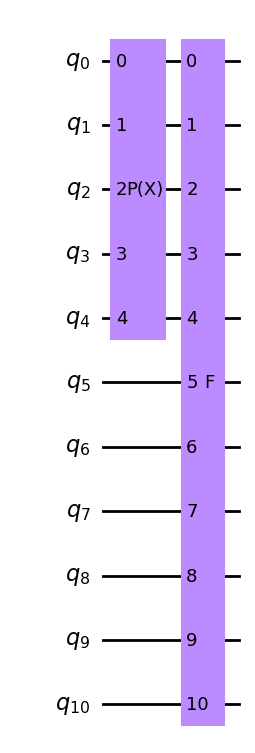

In [11]:
problem.state_preparation.draw('mpl')

We will select IonQ's device and see how much it could cost us a single run on it. We need to decompose the circuit to basic gates that can be interpreted by IonQ.

In [27]:
from qiskit import transpile

result = transpile(problem.state_preparation, basis_gates=['id', 'ry', 'rx', 'rz', 'cx', 'h'], optimization_level=1, seed_transpiler=1)

backend = provider.get_backend("quantinuum.qpu.h1-1")
costs = backend.estimate_cost(result, shots=1)

print(f" Estimated cost for a single shot is of {costs.estimated_total}{costs.currency_code}")

 Estimated cost for a single shot is of 5.449HQC
